In [169]:
%load_ext autoreload
%autoreload 2

import os 
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('display.width', 2000)

from grid_automate import (root_task, all_runs_csv, get_df_from_configs, 
                           get_seq_4_epochs, calc_media_scarti, plot_scarto, plot_curves_vs_features, get_color,
                          get_data_points_degrees_relative_difference, get_plot_data)

from config_valid import GraphType, get_dataset_trial_string, get_model_trial_string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
head_df = pd.read_csv(all_runs_csv)

In [279]:
df_out = get_df_from_configs(head_df)

In [280]:
#df_out.info()
df_out.shape

(560, 69)

In [65]:
df_out['model.GCNneurons_per_layer'].unique()

array([(1, 32, 16), (1, 32, 1), (1, 2, 2), (1, 2), (1, 8, 4),
       (1, 256, 32), (1, 4, 1), (1, 16, 16, 8), (1, 8, 4, 2), (1, 4, 2),
       (1, 1), (1, 32, 32, 32), (1, 64, 32), (1, 256, 128, 64),
       (1, 64, 64, 8), (1, 16, 4), (1, 8, 8, 8, 8, 4), (1, 256, 32, 32),
       (1, 2, 1), (1, 200, 1), (1, 32, 32), (1, 64, 64, 32), (1, 8, 8),
       (1, 256, 8), (1, 64, 16), (1, 100, 1), (1, 32, 32, 8),
       (1, 64, 32, 16, 16), (1, 16, 16, 4), (1, 4, 4), (1, 4, 3),
       (1, 128, 128, 64, 32, 16), (1, 16, 1), (1, 512, 64),
       (1, 32, 16, 16), (1, 8, 1), (1, 128, 32), (1, 256, 64),
       (1, 64, 64), (1, 256, 128, 128), (1, 250, 1), (1, 256, 128, 16),
       (1, 16, 16, 16), (1, 16, 8)], dtype=object)

# Maschere e selezione: esplorazione dei run eseguiti

### le variabili che mi interessano ora sono:
1. Inizializzazione dei pesi

2. Modello di gnn usato per l'autoencoder

3. Architettura del modello

4. tipo di dataset

5. numero di nodi e 

6. numero di grafi del dataset

7. loss usata per il training e obiettivo del training

8. matrice di adiacenza normalizzata oppure no

In [281]:
def mask_init_ws(df_out, s):
    return df_out['model.init_weights'] == s

def mask_model(df_out, s):
    model = get_model_trial_string(s)
    return df_out[f'model.{model}'] == True

def mask_architecture(df_out, s):
    return df_out['model.GCNneurons_per_layer'] == tuple(s)

def mask_dataset(df_out, graphtype_class):
    return df_out[get_dataset_trial_string(graphtype_class)] == True

def mask_cm_exp(df_out, exp_interval):
    maxim, minim = exp_interval[1], exp_interval[0]
    m1 = df_out['graph_dataset.list_exponents'] >= (minim,) 
    m2 = df_out['graph_dataset.list_exponents'] <= (maxim,) 
    return m1 & m2

def mask_nodi(df_out, num_nodes):
    return df_out['graph_dataset.Num_nodes'] == num_nodes

def mask_ngrafi(df_out, n):
    return df_out['graph_dataset.Num_grafi_per_tipo'] == n

def mask_loss(df_out, ):
    return df_out

def mask_adj_norm(df_out):
    return df_out['model.normalized_adj'].fillna(True) == True


def show_selection(mask):
    return(head_df[mask])

In [282]:
# 1. maschere per i pesi iniziali
m_init_xavier =  mask_init_ws(df_out, 'xavier_normal')
m_init_eye = mask_init_ws(df_out, 'eye')

# 2.  maschere per i modelli
m_simple_ae = mask_model(df_out, 'AE')
m_aecm = mask_model(df_out, 'AE_CM')

# 3. maschere per le architetture
m_arch_1_8_4 = mask_architecture(df_out, (1,8,4))
m_arch_1_32_1 = mask_architecture(df_out, (1,32,1))
m_arch_1_32_16 = mask_architecture(df_out, (1,32,16))

# 4. maschere per i  dataset
m_erdos = mask_dataset(df_out, GraphType.ER)
m_powerlaw = mask_dataset(df_out, GraphType.CM)

m_exponent_neg = mask_cm_exp(df_out, (-50,0))

# 5. maschere per i nodi
m_nodi_300 = mask_nodi(df_out, (300,))
m_nodi_500 = mask_nodi(df_out, (500,))
m_nodi_800 = mask_nodi(df_out, (800,))

# 6. maschere per il numero dei grafi
m_grafi = mask_ngrafi(df_out, 40)

# 7. maschere per la loss di training
m_loss_bce = df_out['training.loss'] == 'BCELoss'

# 8. maschere per matrice di adiacenza
m_normalize_gcn_layer = mask_adj_norm(df_out)
m_UNnormalize_gcn_layer = ~m_normalize_gcn_layer

### Scarto VS p Erdos-Renyi 

In [120]:
tot_mask_xavier_ER_AE__1_8_4__adjnorm_300_40 = m_init_xavier & m_erdos & m_simple_ae & m_arch_1_8_4  & m_nodi & m_grafi
show_selection(tot_mask_xavier_ER_AE__1_8_4__adjnorm_300_40)

,folders
36,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
164,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
196,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
349,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
430,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss


In [121]:
tot_mask_xavier_ER_AECM__1_8_4__adjnorm_300_40 = m_init_xavier & m_erdos & m_aecm & m_arch_1_8_4 & m_nodi & m_grafi
show_selection(tot_mask_xavier_ER_AECM__1_8_4__adjnorm_300_40)

,folders
178,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
212,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
417,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
432,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
475,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss


In [122]:
tot_mask_xavier_ER_AE_adjnorm_300_40 = m_init_xavier & m_erdos & m_simple_ae & m_nodi & m_grafi
show_selection(tot_mask_xavier_ER_AE_adjnorm_300_40)

,folders
36,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
38,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
164,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
181,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr8e-05_ADAMW_BCELoss
196,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
251,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
259,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
279,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
349,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
398,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss


In [130]:
show_selection( m_init_xavier & m_erdos & m_simple_ae & m_arch_1_32_16 )

,folders
259,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss


### Scarto VS exp power law

In [283]:
tot_mask_xavier_CM_AECM_adjnorm_300_40 = m_init_xavier & m_powerlaw & m_aecm & m_nodi & m_grafi & m_normalize_gcn_layer
show_selection(tot_mask_xavier_CM_AECM_adjnorm_300_40)

,folders
2,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[13]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
63,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-13]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
83,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
291,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-21]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
304,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-40]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
430,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-13]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
438,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
487,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
556,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-21]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-128-128-64-32-16§__ELU+RELU__grphnorm__-xavier_normal___#__lr4e-05_ADAMW_BCELoss


In [284]:
tot_mask_xavier_CM_AE_adjnorm_300_40 = m_init_xavier & m_powerlaw & m_simple_ae & m_nodi_300 & m_grafi & m_normalize_gcn_layer
show_selection(tot_mask_xavier_CM_AE_adjnorm_300_40)

,folders
36,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[30]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
50,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[13]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
72,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[40]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
82,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-13]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
120,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[12]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
127,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-21]_Classi-1_nodi300_grafiX40___#__AE_________§1-128-128-64-32-16§__ELU+RELU__grphnorm__-xavier_normal___#__lr4e-05_ADAMW_BCELoss
177,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
221,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
258,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
302,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss


In [285]:
tot_mask_xavier_CM_AE_adjnorm_500_40 = m_init_xavier & m_powerlaw & m_simple_ae & m_nodi_500 & m_grafi & m_normalize_gcn_layer
show_selection(tot_mask_xavier_CM_AE_adjnorm_500_40)

,folders
117,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-09]_Classi-1_nodi500_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
142,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi500_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
237,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-03]_Classi-1_nodi500_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
435,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-07]_Classi-1_nodi500_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
553,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-05]_Classi-1_nodi500_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss


In [286]:
tot_mask_xavier_CM_AE_adjnorm_800_40 = m_init_xavier & m_powerlaw & m_simple_ae & m_nodi_800 & m_grafi & m_normalize_gcn_layer
show_selection(tot_mask_xavier_CM_AE_adjnorm_800_40)

,folders
17,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-05]_Classi-1_nodi800_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
96,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-07]_Classi-1_nodi800_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
248,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-09]_Classi-1_nodi800_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
409,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-03]_Classi-1_nodi800_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
502,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi800_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss


### scarto A non normalizzata

In [287]:

tot_mask_xavier_CM_AE_adUNjnorm_300 = m_init_xavier & m_powerlaw & m_simple_ae & m_nodi_300 & m_UNnormalize_gcn_layer
show_selection(tot_mask_xavier_CM_AE_adUNjnorm_300)

,folders
28,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00007_ADAMW_BCELoss
193,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16-16§____ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
200,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-1§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
255,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-16-1§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
344,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
375,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
453,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-2-1§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
468,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00002_ADAMW_BCELoss
489,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-231]_Classi-1_nodi300_grafiX40___#__AE_________§1-16-8§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00001_ADAMW_BCELoss
539,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00001_ADAMW_BCELoss


# Plot dello scarto dalla sequenza di grado, uno per ogni training

In [13]:
def plot_selections(res, ylim=None, xlim=None):
    i = 0
    for index, row in res.iterrows():
        path = row.values[0]
        file_list, epochs, input_seq = get_seq_4_epochs(path)
        epoch = epochs[-1]
        pred_seq = file_list[-1]  # prendo la sequenza di grado dell'ultima epoca
        plot_scarto(epoch, pred_seq, input_seq, ax=None, folder_path=path.split('§_')[0], ylim=ylim, xlim=xlim)    
        i += 1

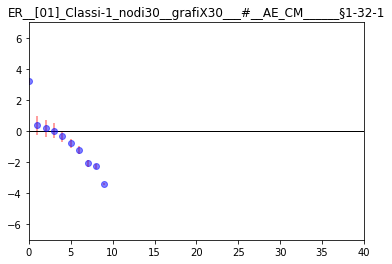

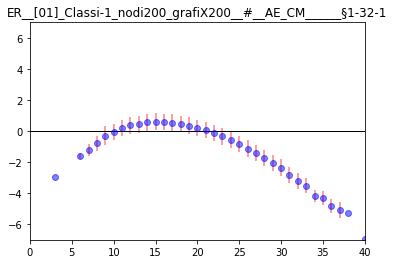

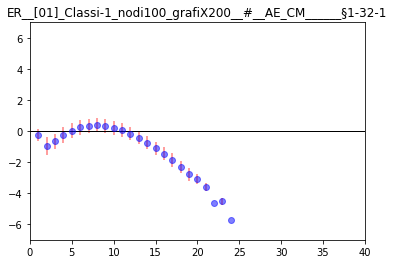

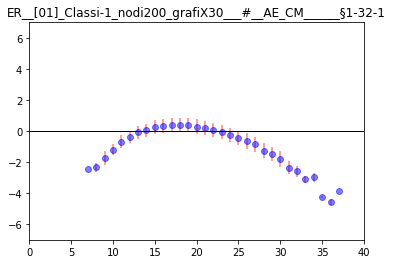

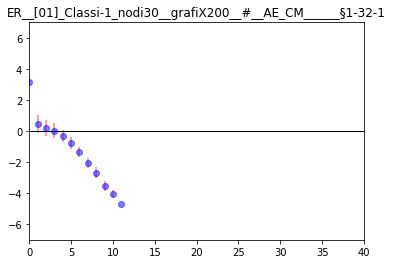

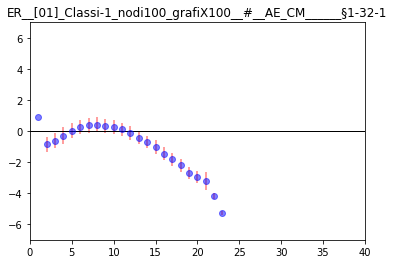

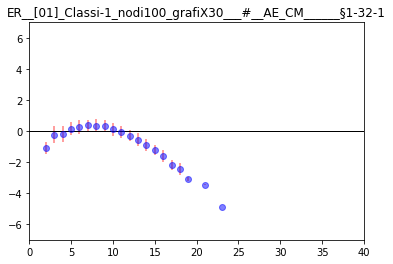

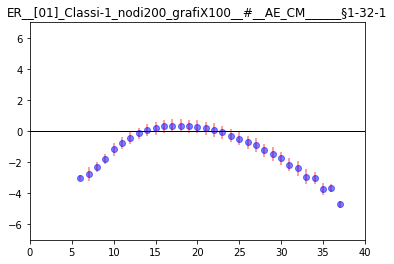

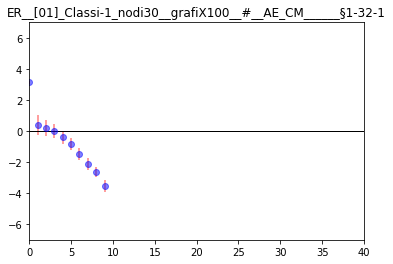

In [14]:
res = head_df[m1 & m_dim_emb_1 & m_data_ER]
#fig, ax = plt.subplots(len(res), 2, figsize=(15,35))
plot_selections(res)

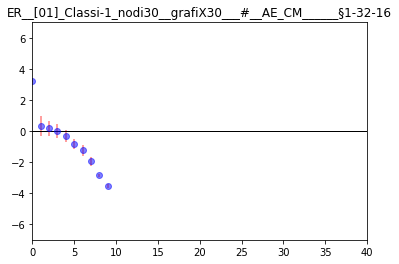

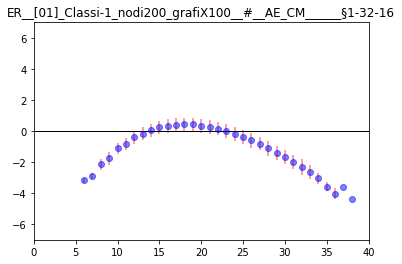

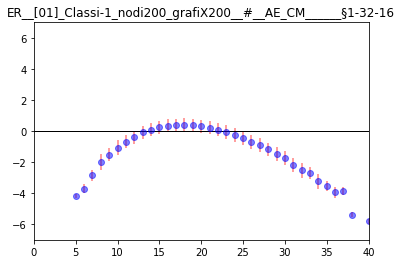

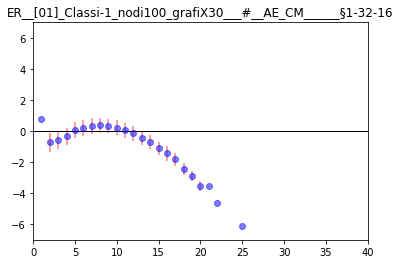

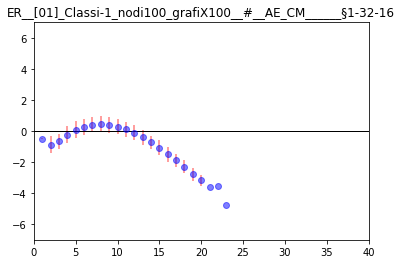

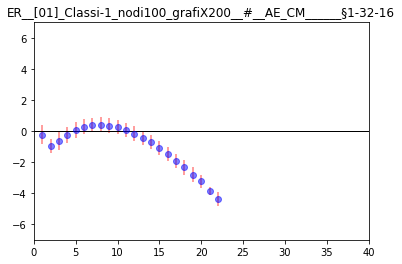

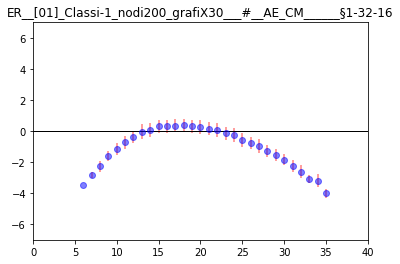

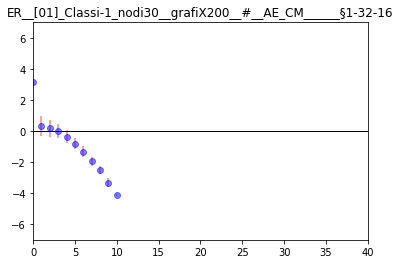

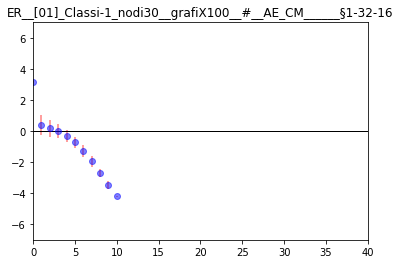

In [7]:
res = head_df[m1 & m_dim_emb_16 & m_data_ER]
#fig, ax = plt.subplots(len(res), 2, figsize=(15,35))
plot_selections(res)

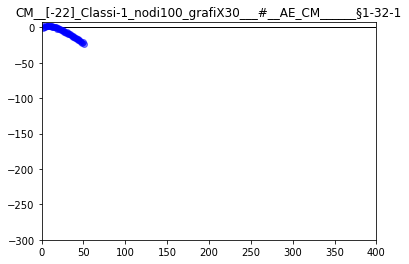

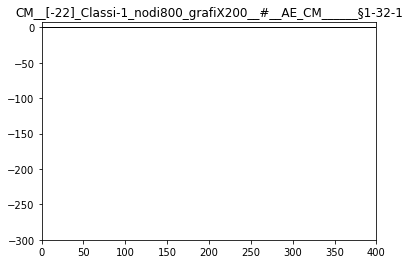

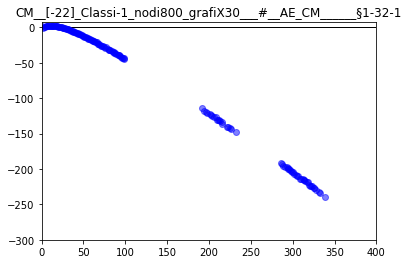

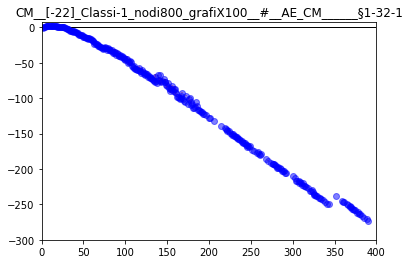

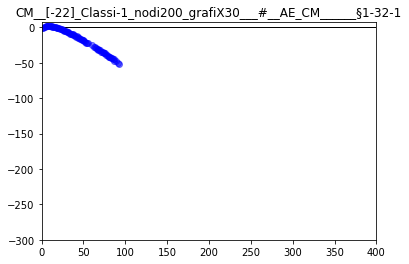

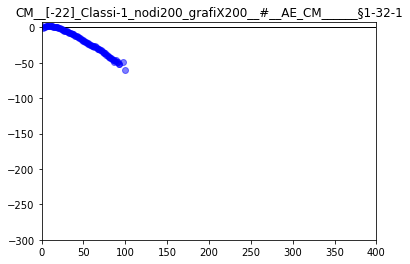

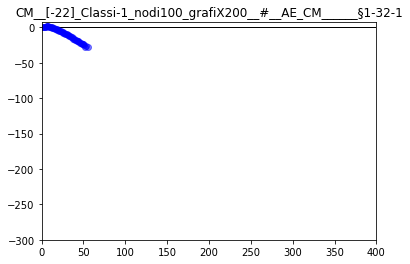

In [17]:
res = head_df[m1 & m_dim_emb_1 & m_data_CM]
#fig, ax = plt.subplots(len(res), 2, figsize=(15,35))
plot_selections(res, ylim=(-300,7), xlim=(0,400))

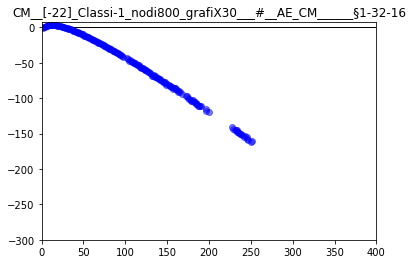

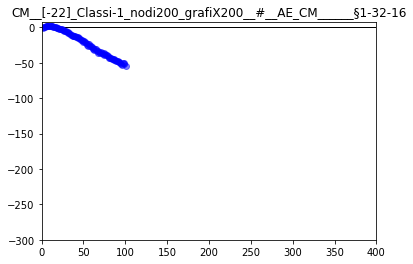

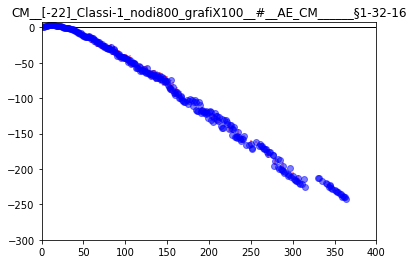

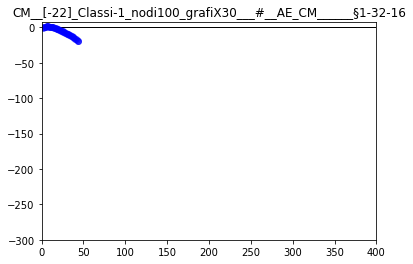

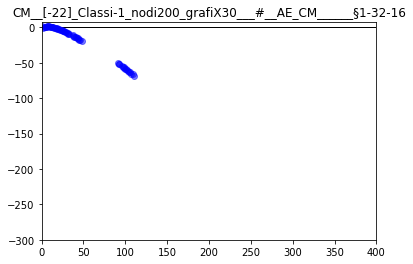

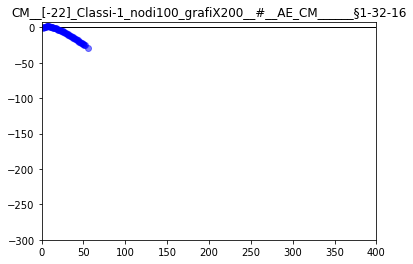

In [18]:
res = head_df[m1 & m_dim_emb_16 & m_data_CM]
#fig, ax = plt.subplots(len(res), 2, figsize=(15,35))
plot_selections(res, ylim=(-300,7), xlim=(0,400))

# Plot dello scarto al variare del p Erdos-Renyi

In [153]:
def extract_data_from_mask(mask, feat, normalize_x=False, probs=False):
    many_training_paths = head_df[mask]
    many_training_configs = df_out[mask]
    plot_data = get_plot_data(many_training_paths, many_training_configs, feat=feat, normalize_x=normalize_x, probs=probs)
    return plot_data

In [38]:
plot_data_ae =   extract_data_from_mask(tot_mask_xavier_ER_AE__1_8_4__adjnorm_300_40, feat='pER', normalize_x=True)
plot_data_aecm = extract_data_from_mask(tot_mask_xavier_ER_AECM__1_8_4__adjnorm_300_40, feat='pER', normalize_x=True)

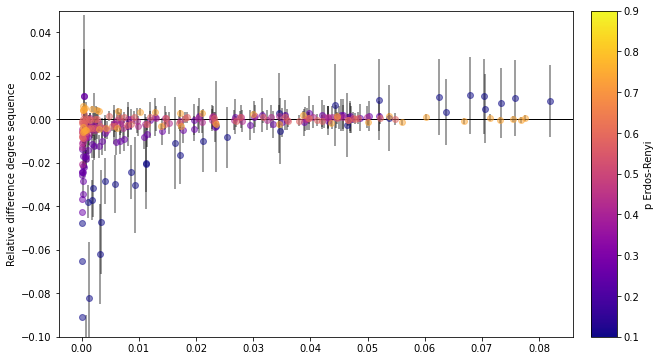

import networkx as nx
gr = nx.erdos_renyi_graph(300, 0.999)
gr.number_of_edges()

### $ \rightarrow$  Sta faticando a ritrovare il grado quando è più lontano dalla media :
i nodi col grado più piccolo o più grande della rete, quando la rete è piccola, sono più difficili dei nodi più piccoli o più grandi quando la rete è grande.

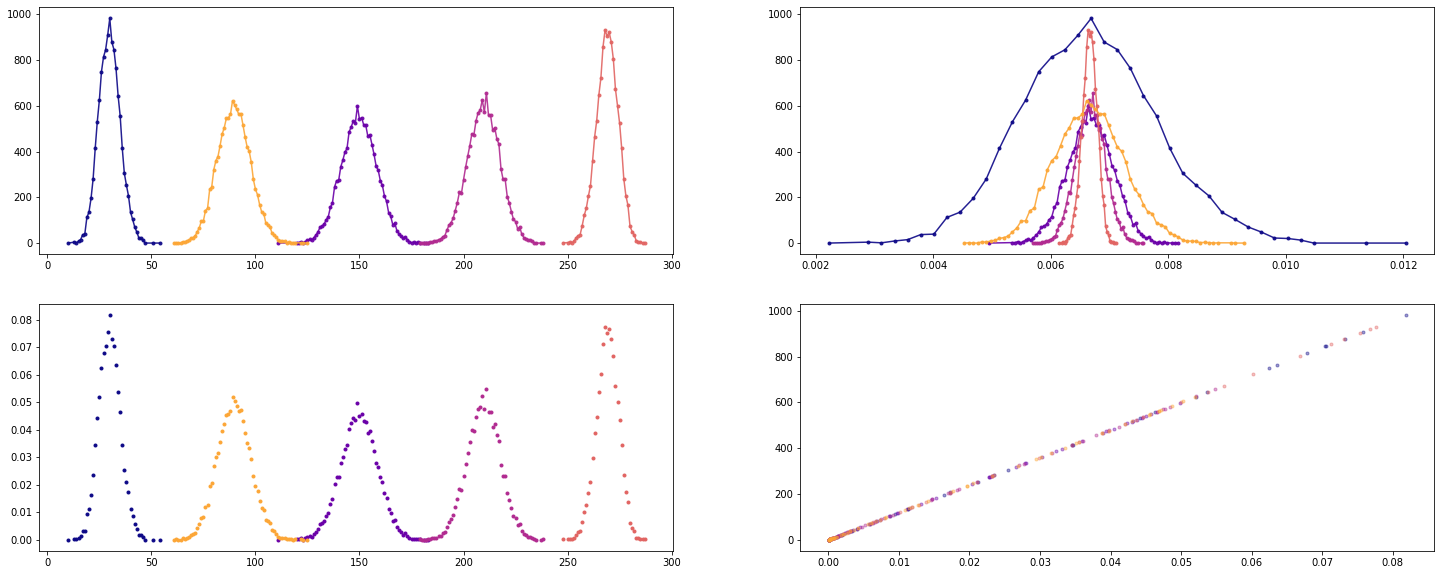

In [43]:
i=0
cm = plt.get_cmap('plasma')
num_colors = len(many_training_paths)
colors = [cm(1. * i / num_colors) for i in range(num_colors)]

fig, ax = plt.subplots(2,2, figsize=(25,10))

for index, row in many_training_paths.iterrows():
    path = row.values[0]
    pred_seq_4_epochs, epochs, input_seq = get_seq_4_epochs(path)
    
    counts = np.unique(input_seq, return_counts=True)
    ax[0][0].plot(*counts, '.-', c=colors[i], alpha=0.9)  #, label="", linewidth=)
        
    num_nodes = many_training_configs.loc[index]['graph_dataset.Num_nodes'][0] 
    pER = many_training_configs.loc[index]['graph_dataset.list_p'][0]
    num_medio_link_grafo = num_nodes * (num_nodes - 1) / 2 * pER    
    
    ax[0][1].plot(*(counts[0]/num_medio_link_grafo, counts[1]), '.-', c=colors[i], alpha=0.9)
    #plt.loglog(*counts, c=colors[0], alpha=0.9, label="", linewidth=3)
    
    
    degree_count = Counter(input_seq)
    # Normalizzazione dei conteggi -> probabilità!
    total_count = sum(degree_count.values())
    deg_prob = {degree: count / total_count for degree, count in degree_count.items()}
    ax[1][0].scatter(deg_prob.keys(), deg_prob.values(), marker= '.', color=colors[i])
    
    probabilities = [deg_prob[degree] for degree in counts[0]]
    ax[1][1].plot(*(probabilities, counts[1]), '.', c=colors[i], alpha=0.4)
    
    
    i+=1

[<AxesSubplot:> <AxesSubplot:>]


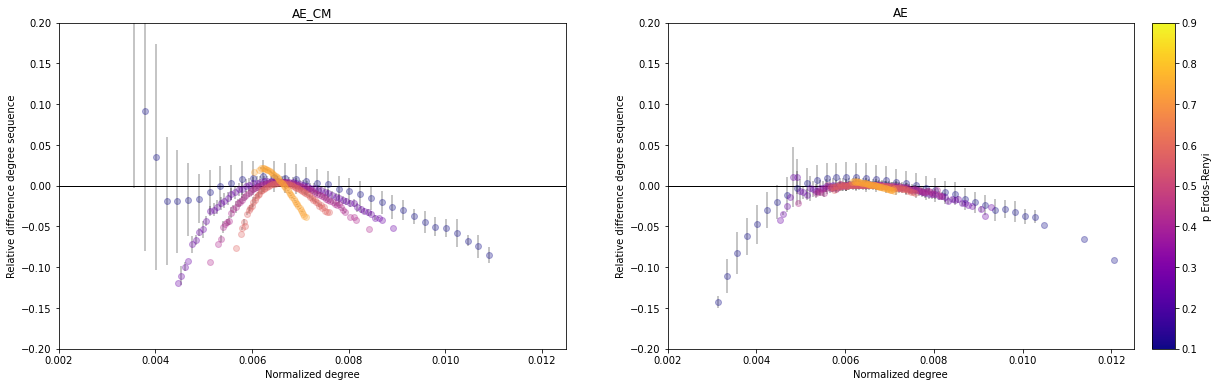

In [45]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_curves_vs_features(plot_data_aecm, titolo='AE_CM', x_title="Normalized degree", x_lim=(0.002, 0.0125), y_lim=(-0.2, 0.2), ax=ax[0], colorbar=False)
plot_curves_vs_features(plot_data_ae, titolo='AE', x_title="Normalized degree", x_lim=(0.002, 0.0125), y_lim=(-0.2, 0.2), ax=ax[1], titolo_laterale='p Erdos-Renyi')
plt.show()

# seq grado Power Law 

 gradi non riscalati rispetto ai link totali

7 31
21 31
26 31
23 31
28 31
19 31
27 41
13 31
32 41
20 31
30 31
22 41
25 31
18 26
8 31
37 41
30 31
10 26
17 31
16 31
30 31
30 31
30 31
49 51
14 31
29 31
15 31
30 31
40 51


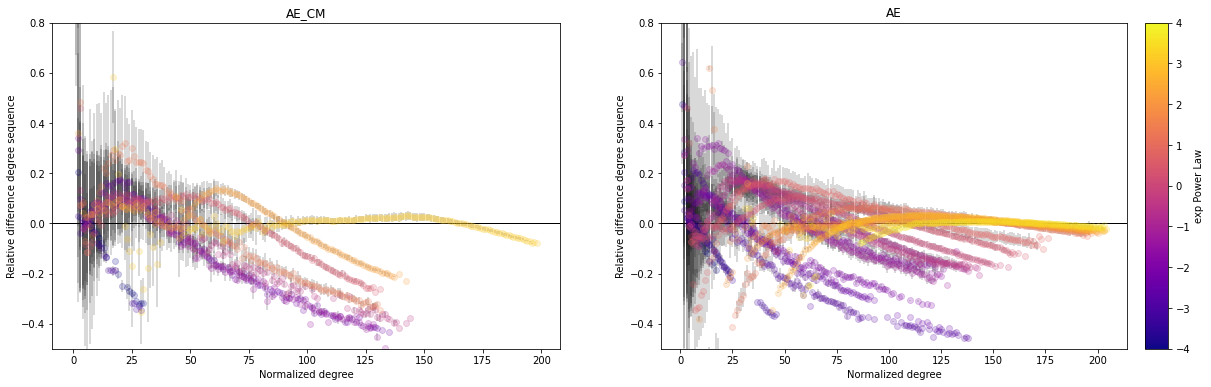

In [288]:
plot_data_pl_ae =   extract_data_from_mask(tot_mask_xavier_CM_AE_adjnorm_300_40, feat='exp', normalize_x=False)
plot_data_pl_aecm = extract_data_from_mask(tot_mask_xavier_CM_AECM_adjnorm_300_40, feat='exp', normalize_x=False)
fig, ax = plt.subplots(1,2, figsize=(20,6))
y_lim = (-0.5, 0.8)
plot_curves_vs_features(plot_data_pl_aecm, titolo='AE_CM', x_title="Normalized degree",  y_lim=y_lim, ax=ax[0], colorbar=False)  ###x_lim=x_lim, y_lim=y_lim,
plot_curves_vs_features(plot_data_pl_ae, titolo='AE', x_title="Normalized degree", y_lim=y_lim, ax=ax[1], titolo_laterale='exp Power Law')   ###x_lim=x_lim, y_lim=y_lim,
plt.show()

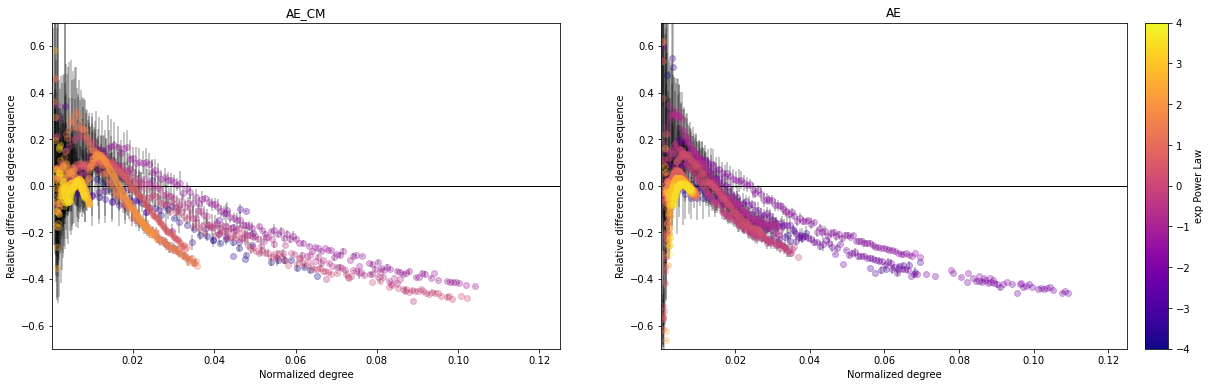

7 31
21 31
26 31
23 31
28 31
19 31
27 41
13 31
32 41
20 31
30 31
22 41
25 31
18 26
8 31
37 41
30 31
10 26
17 31
16 31
30 31
30 31
30 31
49 51
14 31
29 31
15 31
30 31
40 51


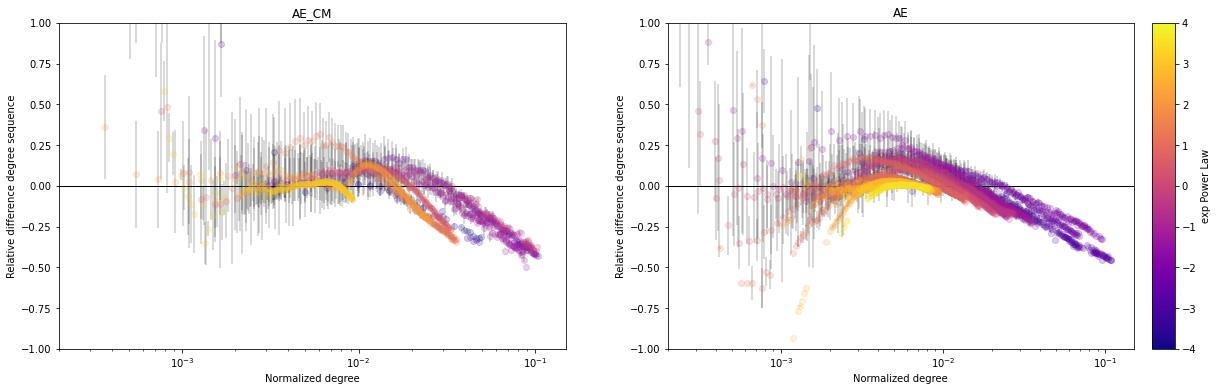

In [292]:
plot_data_pl_ae =   extract_data_from_mask(tot_mask_xavier_CM_AE_adjnorm_300_40, feat='exp', normalize_x=True)
plot_data_pl_aecm = extract_data_from_mask(tot_mask_xavier_CM_AECM_adjnorm_300_40, feat='exp', normalize_x=True)

fig, ax = plt.subplots(1,2, figsize=(20,6))
x_lim, y_lim = (0.0002, 0.15), (-1.0, 1.0)
plot_curves_vs_features(plot_data_pl_aecm, titolo='AE_CM', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[0], colorbar=False)
#display(show_selection(tot_mask_xavier_CM_AECM_adjnorm_300_40))
plot_curves_vs_features(plot_data_pl_ae, titolo='AE', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[1], titolo_laterale='exp Power Law')
#display(show_selection(tot_mask_xavier_CM_AE_adjnorm_300_40))
plt.show()

In [293]:
tot_mask_xavier_CM40_AE_adjnorm_300_40 = m_init_xavier & m_powerlaw & m_simple_ae & m_nodi_300 & m_grafi & m_normalize_gcn_layer  & m_arch_1_32_1
show_selection(tot_mask_xavier_CM40_AE_adjnorm_300_40)

,folders
36,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[30]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
82,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-13]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
120,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[12]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
324,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-40]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss


7 31
23 31
28 31
30 31


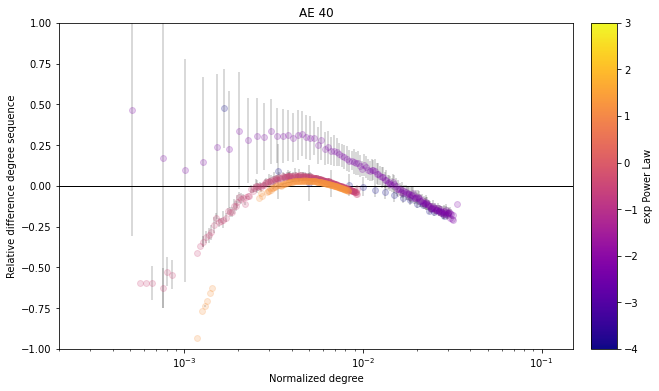

In [294]:
plot_data_pl_ae40 = extract_data_from_mask(tot_mask_xavier_CM40_AE_adjnorm_300_40, feat='exp', normalize_x=True)
x_lim, y_lim = (0.0002, 0.15), (-1.0, 1.0)
#plot_curves_vs_features(plot_data_pl_aecm, titolo='AE_CM', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[0], colorbar=False)
plot_curves_vs_features(plot_data_pl_ae40, titolo='AE 40', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, titolo_laterale='exp Power Law')

28 41
24 41
25 41
0 41
40 41
33 41
32 41
16 41
9 41
30 41


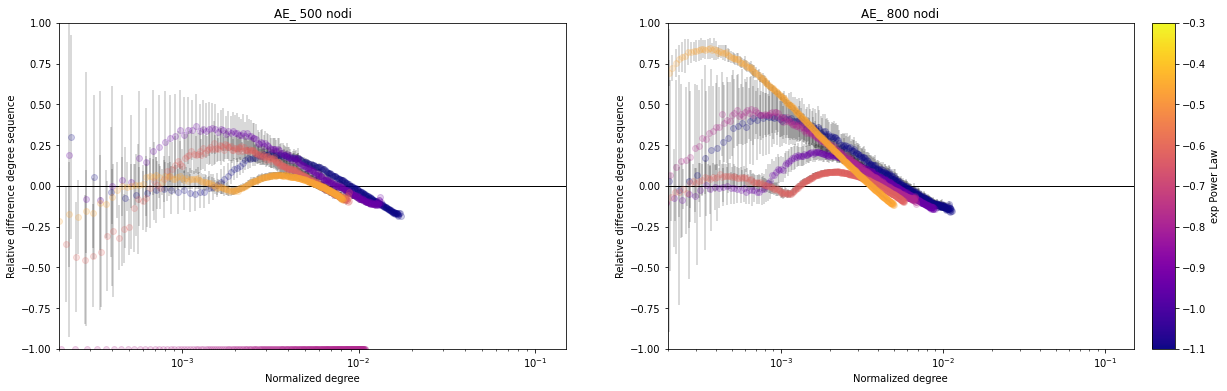

In [295]:
plot_data_pl_ae_500 = extract_data_from_mask(tot_mask_xavier_CM_AE_adjnorm_500_40, feat='exp', normalize_x=True)
plot_data_pl_ae_800 = extract_data_from_mask(tot_mask_xavier_CM_AE_adjnorm_800_40, feat='exp', normalize_x=True)

fig, ax = plt.subplots(1,2, figsize=(20,6))
x_lim, y_lim = (0.0002, 0.15), (-1.0, 1.0)
plot_curves_vs_features(plot_data_pl_ae_500, titolo='AE_ 500 nodi', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[0], colorbar=False)
plot_curves_vs_features(plot_data_pl_ae_800, titolo='AE_ 800 nodi', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[1], titolo_laterale='exp Power Law')
plt.show()

23 31
19 31
27 41
13 31
32 41
20 31
30 31
22 41
18 26
8 31
37 41
30 31
16 31
30 31
30 31
49 51
14 31
29 31
15 31
30 31
40 51


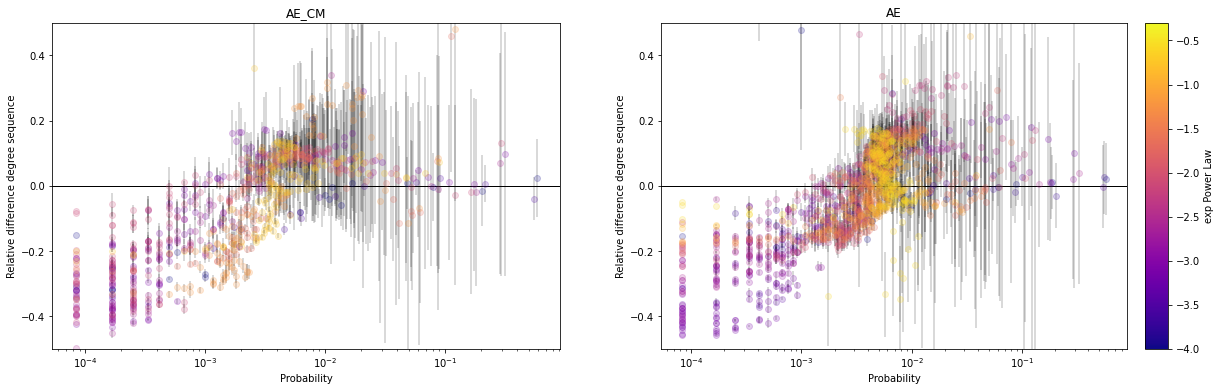

In [296]:
plot_data_pl_ae =   extract_data_from_mask(tot_mask_xavier_CM_AE_adjnorm_300_40 & m_exponent_neg, feat='exp', probs=True)
plot_data_pl_aecm = extract_data_from_mask(tot_mask_xavier_CM_AECM_adjnorm_300_40 & m_exponent_neg, feat='exp', probs=True)
fig, ax = plt.subplots(1,2, figsize=(20,6))
y_lim = (-0.5, 0.5)
plot_curves_vs_features(plot_data_pl_aecm, titolo='AE_CM', x_title="Probability",  y_lim=y_lim, logx=True, ax=ax[0], colorbar=False)  ###x_lim=x_lim, y_lim=y_lim,
plot_curves_vs_features(plot_data_pl_ae, titolo='AE', x_title="Probability", y_lim=y_lim, logx=True, ax=ax[1], titolo_laterale='exp Power Law')   ###x_lim=x_lim, y_lim=y_lim,
plt.show()

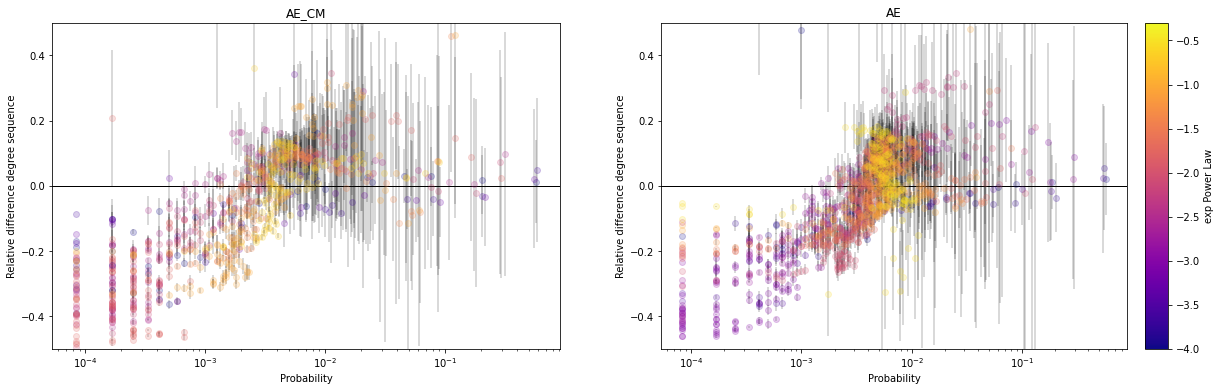

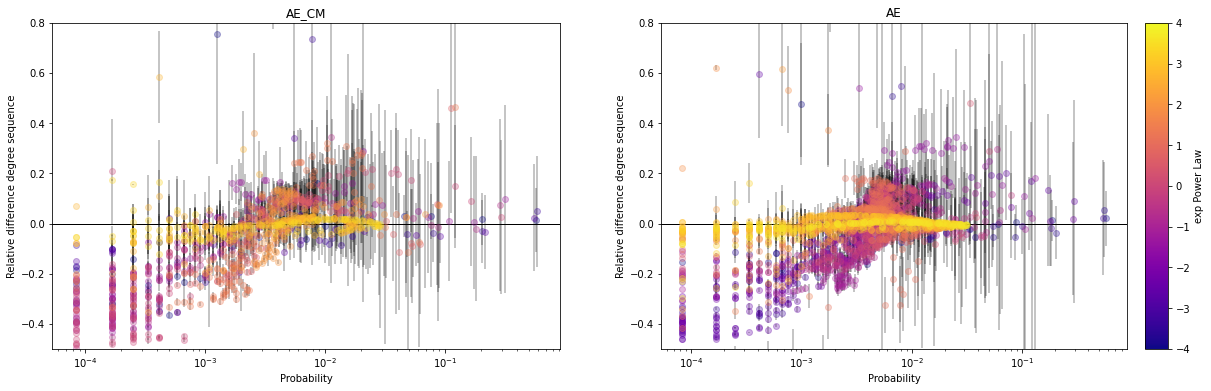

18 31
16 41
14 21
19 21
30 31
30 31
20 21
30 31
35 41
18 41


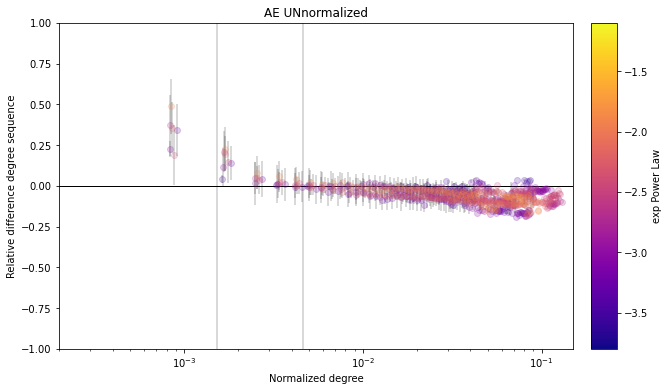

In [297]:
plot_data_pl_ae_UNnorm = extract_data_from_mask(tot_mask_xavier_CM_AE_adUNjnorm_300, feat='exp', normalize_x=True)
x_lim, y_lim = (0.0002, 0.15), (-1.0, 1.0)
#plot_curves_vs_features(plot_data_pl_aecm, titolo='AE_CM', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, ax=ax[0], colorbar=False)
plot_curves_vs_features(plot_data_pl_ae_UNnorm, titolo='AE UNnormalized', x_title="Normalized degree", x_lim=x_lim, y_lim=y_lim, logx=True, titolo_laterale='exp Power Law')

In [190]:
many_training_paths

,folders
36,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[30]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
50,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[13]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
72,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[40]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-16§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
82,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-13]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
119,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[12]_Classi-1_nodi300_grafiX40___#__AE_________§1-32-1§________ELU+RELU__grphnorm__-xavier_normal_#__lr00007_ADAMW_BCELoss
126,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-21]_Classi-1_nodi300_grafiX40___#__AE_________§1-128-128-64-32-16§__ELU+RELU__grphnorm__-xavier_normal___#__lr4e-05_ADAMW_BCELoss
176,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
220,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
257,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss
284,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-05]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00005_ADAMW_BCELoss


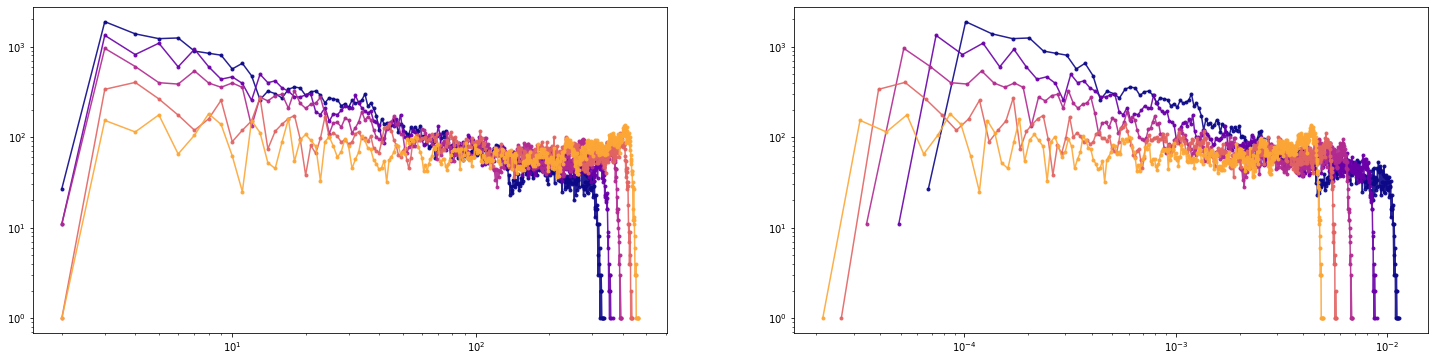

In [194]:
many_training_paths = head_df[tot_mask_xavier_CM_AE_adjnorm_800_40]
many_training_configs = df_out[tot_mask_xavier_CM_AE_adjnorm_800_40]

plot_input_data = []
for index, row in many_training_paths.iterrows():
    path = row.values[0]
    _, _, input_seq, prop = get_seq_4_epochs(path)
    exp = many_training_configs.loc[index]['graph_dataset.list_exponents'][0]
    
    counts = np.unique(input_seq, return_counts=True)
     
    num_grafi = prop[0]
    tot_links = sum(input_seq) / 2 / num_grafi
    
    plot_input_data.append({'counts': counts, 'tot_links': tot_links, 'exp': exp})
    
plot_input_data.sort(key=lambda x: x['exp'])

fig, ax = plt.subplots(1,2, figsize=(25,6))
colors, cm = get_color(plot_input_data)
for i, data in enumerate(plot_input_data):
    counts, tot_links, exp = data['counts'], data['tot_links'], data['exp']
    ax[0].loglog(*counts, '.-', c=colors[i], alpha=0.9) 
    ax[1].loglog(*(counts[0]/tot_links, counts[1]), '.-', c=colors[i], alpha=0.9)   # , alpha=0.9, label="", linewidth=3)

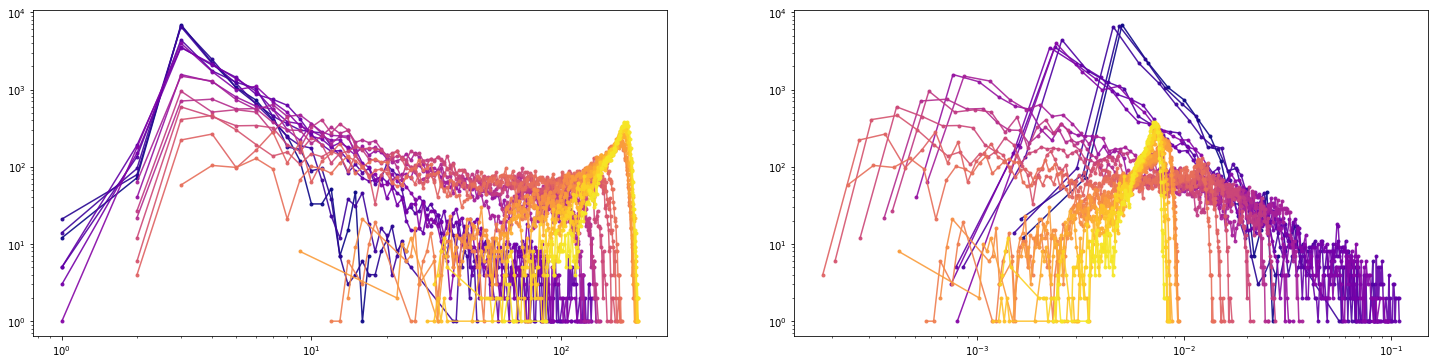

# Many layers

## Power law

In [84]:
m_init = df_out['model.init_weights'] == 'xavier_normal'
m_data_CM = df_out['graph_dataset.confmodel'] == True
#df_out['graph_dataset.list_p'] = df_out['graph_dataset.list_p'].apply(lambda x: tuple(x))
#m_dataset2 = df_out['graph_dataset.list_p'] == (0.1)


m_archit = df_out['model.GCNneurons_per_layer'] == (1,8,8,8,8,4)

m_normalize_gcn_layer = df_out['model.normalized_adj'] != False

m_loss_bce = df_out['training.loss'] == 'BCELoss'


m_model = df_out['model.autoencoder_confmodel'] == True
tot_mask_aecm = m_init & m_data_CM & m_model & m_archit & m_loss_bce & m_normalize_gcn_layer

m_model = df_out['model.autoencoder'] == True
tot_mask_ae = m_init & m_data_CM & m_model & m_archit & m_loss_bce & m_normalize_gcn_layer




In [45]:
many_training_paths = head_df[tot_mask_aecm]
many_training_configs = df_out[tot_mask_aecm]
display(many_training_paths)
plot_data1 = get_plot_data(many_training_paths, feat='exp')

many_training_paths = head_df[tot_mask_ae]
many_training_configs = df_out[tot_mask_ae]
display(many_training_paths)
plot_data2 = get_plot_data(many_training_paths, feat='exp')

,folders
80,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
280,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-21]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
425,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
473,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss


,folders
213,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-38]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
291,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-11]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
464,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss


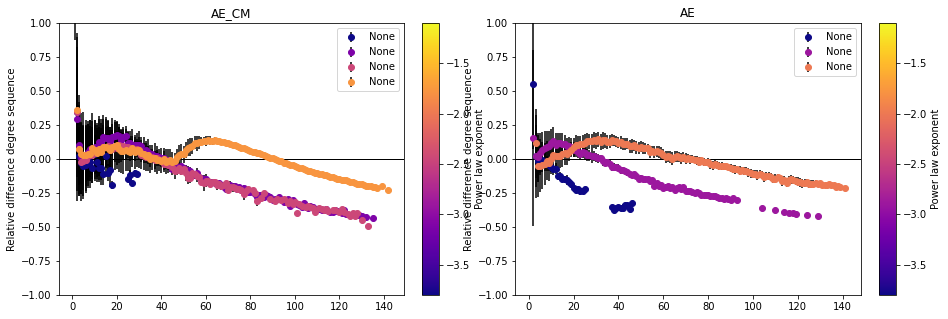

In [46]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
plot_curves_vs_features(plot_data1, y_lim=(-1,1), titolo='AE_CM', titolo_laterale='Power law exponent' ,ax=ax[0])   #p Erdos-Renyi
plot_curves_vs_features(plot_data2, y_lim=(-1,1), titolo='AE', titolo_laterale='Power law exponent' ,ax=ax[1])   #p Erdos-Renyi


## Erdos Renyi

In [85]:
m_data_ER = df_out['graph_dataset.ERmodel'] == True

m_model = df_out['model.autoencoder_confmodel'] == True
tot_mask_aecm = m_init & m_data_ER & m_model & m_archit & m_loss_bce & m_normalize_gcn_layer

m_model = df_out['model.autoencoder'] == True
tot_mask_ae = m_init & m_data_ER & m_model & m_archit & m_loss_bce & m_normalize_gcn_layer

,folders
283,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
290,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
341,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
357,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
376,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_CM______§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss


,folders
38,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
179,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr8e-05_ADAMW_BCELoss
249,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
277,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
397,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX40___#__AE_________§1-8-8-8-8-4§___ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss


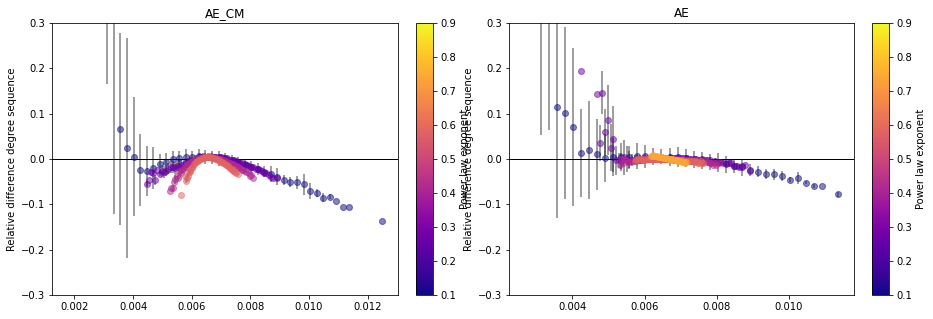

In [88]:
many_training_paths = head_df[tot_mask_aecm]
many_training_configs = df_out[tot_mask_aecm]
display(many_training_paths)
plot_data1 = get_plot_data(many_training_paths,many_training_configs, feat='pER', normalize_x=True)

many_training_paths = head_df[tot_mask_ae]
many_training_configs = df_out[tot_mask_ae]
display(many_training_paths)
plot_data2 = get_plot_data(many_training_paths,many_training_configs, feat='pER', normalize_x=True)

fig,ax = plt.subplots(1,2, figsize=(15,5))
plot_curves_vs_features(plot_data1, y_lim=(-0.3,0.3), titolo='AE_CM', titolo_laterale='Power law exponent' ,ax=ax[0])   #p Erdos-Renyi
plot_curves_vs_features(plot_data2, y_lim=(-0.3,0.3), titolo='AE', titolo_laterale='Power law exponent' ,ax=ax[1])   #p Erdos-Renyi


# 800 nodi

## Erdos

In [102]:

m_nodi = mask_nodi(df_out, (800,))
m_arch = mask_architecture(df_out, (1,8,4))

tot_mask_800_1 = m_init & m_data_ER & m_model & m_loss_bce & m_normalize_gcn_layer & m_nodi & m_arch

In [103]:
many_training_paths = head_df[tot_mask_800_1]
many_training_configs = df_out[tot_mask_800_1]
display(many_training_paths)

plot_data1 = get_plot_data(many_training_paths,many_training_configs, feat='pER', normalize_x=True)

,folders
6,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi800_grafiX21___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
9,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[03]_Classi-1_nodi800_grafiX21___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
273,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi800_grafiX21___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
507,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[05]_Classi-1_nodi800_grafiX21___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss
515,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi800_grafiX21___#__AE_________§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00002_ADAMW_BCELoss


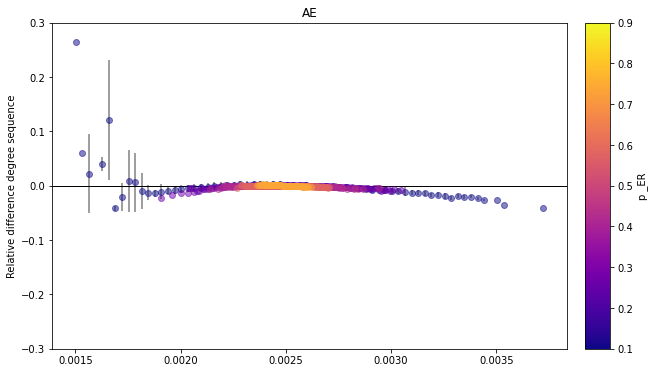

In [104]:
plot_curves_vs_features(plot_data1, y_lim=(-0.3,0.3), titolo='AE', titolo_laterale='p _ER')

## Power law

In [117]:
m_data_CM = df_out['graph_dataset.confmodel'] == True
m_arch = mask_architecture(df_out, (1,8,4))
m_nodi = mask_nodi(df_out, (800,))
tot_mask_800_2 = m_init & m_data_CM & m_model & m_loss_bce & m_normalize_gcn_layer & m_nodi & m_arch

,folders


ValueError: min() arg is an empty sequence

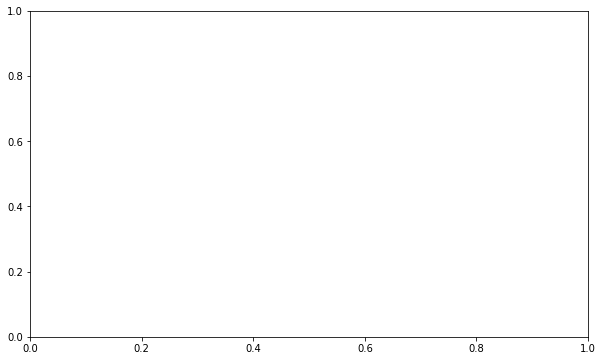

In [118]:
many_training_paths = head_df[tot_mask_800_2]
many_training_configs = df_out[tot_mask_800_2]
display(many_training_paths)

plot_data1 = get_plot_data(many_training_paths,many_training_configs, feat='exp', normalize_x=True)
plot_curves_vs_features(plot_data1, y_lim=(-0.3,0.3), titolo='AE', titolo_laterale='exponent')